# Rigid Body Constraints

In the example, we implement rigid body constraint to a nonlinear material using static condensation

In [1]:
from typing import NamedTuple

import gmsh
import jax
import jax.numpy as jnp
import numpy as np
from jax import Array
from jax_autovmap import autovmap
from tatva import Mesh, Operator

jax.config.update("jax_enable_x64", True)

In [3]:
# [collapse: code] Code for generating a plate with a hole geometry and meshing it.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes


def extract_physical_groups(tag_map: dict) -> dict[str, np.ndarray]:
    print("Extracting physical groups from Gmsh model...")
    physical_surfaces: dict[str, np.ndarray] = {}

    for dim, pg_tag in gmsh.model.getPhysicalGroups(dim=1):
        name = gmsh.model.getPhysicalName(dim, pg_tag)

        # Entities (surface tags) that belong to this physical group
        entities = gmsh.model.getEntitiesForPhysicalGroup(dim, pg_tag)

        els = []
        for ent in entities:
            # Get all mesh elements on this surface entity
            types, _, node_tags_by_type = gmsh.model.mesh.getElements(dim, ent)

            for etype, ntags in zip(types, node_tags_by_type):
                nodes = np.array(ntags, dtype=np.int64).reshape(-1, etype + 1)
                els.append(nodes)

        if not els:
            physical_surfaces[name] = np.zeros((0, 2), dtype=np.int32)
            continue

        group_els = np.vstack(els, dtype=np.int32)
        group_els = np.array(
            [[tag_map[t] for t in tri] for tri in group_els], dtype=np.int32
        )
        physical_surfaces[name] = group_els

    return physical_surfaces



def plot_mesh(mesh: Mesh, ax: Axes | None = None) -> None:
    if ax is None:
        fig, ax = plt.subplots()
    ax.tripcolor(
        mesh.coords[:, 0],
        mesh.coords[:, 1],
        mesh.elements,
        facecolors=np.ones(len(mesh.elements)),
        cmap="managua",
        edgecolors="k",
        linewidth=0.2,
    )
    ax.margins(0, 0)
    ax.set_aspect("equal")

def generate_plate(length: float, height: float, hole_radius: float) -> Mesh:
    y0, y1 = 0 - height / 2, height / 2
    x0, x1 = 0.0, length
    gmsh.initialize()
    gmsh.model.add("plate_with_hole")
    occ = gmsh.model.occ

    # Define the geometry
    p1 = occ.addPoint(x0, y0, 0)
    p2 = occ.addPoint(x1, y0, 0)
    p3 = occ.addPoint(x1, y1, 0)
    p4 = occ.addPoint(x0, y1, 0)

    c1 = occ.addPoint(0, -hole_radius, 0)
    c2 = occ.addPoint(0, hole_radius, 0)
    cmid = occ.addPoint(0, 0, 0)
    c_hole = occ.add_circle_arc(c2, cmid, c1)

    l1 = occ.addLine(p1, p2)
    l2 = occ.addLine(p2, p3)
    l3 = occ.addLine(p3, p4)
    l4 = occ.addLine(p4, c2)
    l5 = c_hole
    l6 = occ.addLine(c1, p1)

    cl = occ.addCurveLoop([l1, l2, l3, l4, l5, l6])
    surface = gmsh.model.occ.addPlaneSurface([cl])

    gmsh.model.occ.synchronize()

    # Refine along the hole boundary
    base_size = min(length, height) / 30
    fine_size = base_size / 3
    dist_field = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(dist_field, "CurvesList", [c_hole])
    thresh_field = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(thresh_field, "InField", dist_field)
    gmsh.model.mesh.field.setNumber(thresh_field, "SizeMin", fine_size)
    gmsh.model.mesh.field.setNumber(thresh_field, "SizeMax", base_size)
    gmsh.model.mesh.field.setNumber(thresh_field, "DistMin", hole_radius * 0.25)
    gmsh.model.mesh.field.setNumber(thresh_field, "DistMax", hole_radius * 1.25)
    gmsh.model.mesh.field.setAsBackgroundMesh(thresh_field)

    # Mesh the geometry
    gmsh.model.mesh.generate(2)

    gmsh.model.addPhysicalGroup(2, [surface], 2, "plate_surface")
    gmsh.model.addPhysicalGroup(1, [c_hole], 1, "hole_boundary")
    gmsh.model.addPhysicalGroup(1, [l4, l6], 3, "left_edge")
    gmsh.model.addPhysicalGroup(1, [l2], 4, "right_edge")
    gmsh.model.addPhysicalGroup(1, [l1], 5, "bottom_edge")
    gmsh.model.addPhysicalGroup(1, [l3], 6, "top_edge")

    # Extract nodes and elements
    node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
    tag_map = {tag: i for i, tag in enumerate(node_tags)}
    nodes = jnp.array(node_coords).reshape(-1, 3)[:, :2]

    elem_types, elem_tags, elem_node_tags = gmsh.model.mesh.getElements(2)
    elements = jnp.array(elem_node_tags[0]).reshape(-1, 3) - 1

    pg = extract_physical_groups(tag_map)
    gmsh.finalize()
    return Mesh(nodes, elements=elements), pg



## Creating Mesh

We define a plate with a hole at its center. Because of symmetry we only model, one half of the plate.


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.00501475s, CPU 0.005614s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.12732s, CPU 0.120661s)
Info    : 3518 nodes 7039 elements
Extracting physical groups from Gmsh model...


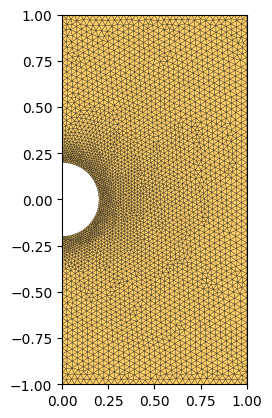

In [4]:
lx = 1.0
ly = 2.0
r = 0.2
mesh, pg = generate_plate(lx, ly, r)
n_dofs_per_node = 2
n_nodes = mesh.coords.shape[0]
n_dofs = n_dofs_per_node * n_nodes
plot_mesh(mesh)

To define rigid body constraint, we define a rigid disk of radius = 0.15, which is attached to the top right part of the plate. 

In [5]:
radius = 0.15
disk_center = jnp.array([lx * 3 / 4, ly / 2 * 3 / 4])
disk_nodes = jnp.where(
    jnp.linalg.norm(mesh.coords - disk_center, axis=1) < (radius + 1e-12)
)[0]

We can now define the `Operator` object which takes the mesh and the associated element type which in this case is `Tri3`.

In [6]:
from tatva.element import Tri3
op = Operator(mesh, Tri3())

## Defining boundaries

We start with identify the degrees of freedom associated with boundaries


In [8]:
boundary_left = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
boundary_right = jnp.where(jnp.isclose(mesh.coords[:, 0], lx))[0]
point_at_y_0 = jnp.where(
    jnp.isclose(mesh.coords[:, 0], lx) & jnp.isclose(mesh.coords[:, 1], 0.0)
)[0][0]
boundary_left_bottom = jnp.where(
    (jnp.isclose(mesh.coords[:, 0], 0.0)) & (mesh.coords[:, 1] < 0.0)
)[0]

fixed_dofs = jnp.concatenate(
    [
        boundary_left_bottom * n_dofs_per_node,  # u_x = 0 at left-bottom nodes
        jnp.array([n_dofs + 1]),
    ]
)

free_dofs = jnp.setdiff1d(
    jnp.arange(mesh.coords.shape[0] * n_dofs_per_node + 3), fixed_dofs
)

## Defining constraints

To apply the symmetric boundary conditions and the rigid body constraints we define to functions that take the displacements and assign the appropriate boundary conditions.


In [9]:
@jax.jit
def apply_dirichlet_bc(u_flat: Array) -> Array:
    u_flat = u_flat.at[fixed_dofs].set(0.0)
    return u_flat


@jax.jit
def apply_rigid_body_bc(u_flat: Array) -> Array:
    ux_c, uy_c, theta_c = u_flat[-3:]
    vecs = mesh.coords[disk_nodes] - disk_center

    cos, sin = jnp.cos(theta_c), jnp.sin(theta_c)
    rotation_matrix = jnp.array([[cos, -sin], [sin, cos]])
    rotated_vecs = vecs @ rotation_matrix.T
    u_rotation = rotated_vecs - vecs
    u_rigid = jnp.stack([ux_c, uy_c]) + u_rotation
    # Set the displacements at the disk nodes
    u_flat = u_flat.at[disk_nodes * n_dofs_per_node].set(u_rigid[:, 0])
    u_flat = u_flat.at[disk_nodes * n_dofs_per_node + 1].set(u_rigid[:, 1])
    return u_flat

## Defining Energy Functional

We are now in a position to define the total global energy functional 

In [10]:
class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float
    lmbda: float

    @classmethod
    def from_youngs_poisson_2d(
        cls, E: float, nu: float, plane_stress: bool = False
    ) -> "Material":
        mu = E / 2 / (1 + nu)
        if plane_stress:
            lmbda = 2 * nu * mu / (1 - nu)
        else:
            lmbda = E * nu / (1 - 2 * nu) / (1 + nu)
        return cls(mu=mu, lmbda=lmbda)


mat = Material.from_youngs_poisson_2d(1, 0.3)


# Hyperelastic material model
@autovmap(grad_u=2)
def compute_deformation_gradient(grad_u):
    return jnp.eye(2) + grad_u


@autovmap(grad_u=2, mu=0, lmbda=0)
def strain_energy_mpc(grad_u, mu, lmbda):
    F = compute_deformation_gradient(grad_u)
    C = F.T @ F
    J = jnp.linalg.det(F)
    return (
        mat.mu / 2 * (jnp.trace(C) - 2)  # 2D case
        - mat.mu * jnp.log(J)
        + (mat.lmbda / 2) * (jnp.log(J)) ** 2
    )


def total_energy_mpc_full(u_flat: Array) -> Array:
    """Compute the total energy of the system."""
    u = u_flat[:-3].reshape(-1, n_dofs_per_node)
    e_density = strain_energy_mpc(op.grad(u), mat.mu, mat.lmbda)
    return op.integrate(e_density)


def total_energy_mpc(u_free: Array) -> Array:
    """Compute the total energy of the system."""
    u_full = (
        jnp.zeros(n_dofs + 3).at[free_dofs].set(u_free)
    )  # +3 for the rigid body DOFs
    u_full = apply_dirichlet_bc(u_full)
    u_full = apply_rigid_body_bc(u_full)
    return total_energy_mpc_full(u_full)


residual_mpc = jax.jacrev(total_energy_mpc)

In [11]:
# [Collapse: code] Newton-Krylov solver for the nonlinear system.

from functools import partial

@partial(jax.jit, static_argnames=["gradient","compute_tangent"])
def newton_krylov_solver(
    u,
    gradient,
    compute_tangent,
):
    residual = gradient(u)
    norm_res = jnp.linalg.norm(residual)

    init_val = (u, 0, norm_res)

    def cond_fun(state):
        u, iiter, norm_res = state
        return jnp.logical_and(norm_res > 1e-8, iiter < 10)

    def body_fun(state):
        u, iiter, norm_res = state
        residual = gradient(u)

        A = jax.jit(partial(compute_tangent, u_prev=u))
       
        du, _ = jax.scipy.sparse.linalg.cg(A=A, b=-residual)
       
        u = u + du

        residual = gradient(u)
        norm_res = jnp.linalg.norm(residual)

        return (u, iiter + 1, norm_res)

    final_u, final_iiter, final_norm = jax.lax.while_loop(cond_fun, body_fun, init_val)
    jax.debug.print("  Residual: {res:.2e}", res=final_norm)

    return final_u, final_norm

We move the disk in the right direction while keeping its y position fixed. The disk is allowed to rotate $\theta$ such that the disk experiences no moment about its center.

In [12]:
u_disk_x_dof = -2  # hardcoded last 2 dofs correspond to u_disk (one is fixed by BC)


@jax.jit
def func_mpc(u_free: Array) -> Array:
    res = residual_mpc(u_free)
    return res.at[u_disk_x_dof].add(-0.02)

def compute_tangent(du, u_prev):
    tangent = jax.jvp(func_mpc, (u_prev,), (du,))[1]
    return tangent


## Solving the system

We solve the system for the applied rigid body displacement.

In [13]:
f_ext = jnp.zeros(len(free_dofs))

u_sol, norm_res  = newton_krylov_solver(
    u=jnp.zeros_like(f_ext),
    gradient=func_mpc,
    compute_tangent=compute_tangent,
)

  Residual: 8.96e-11


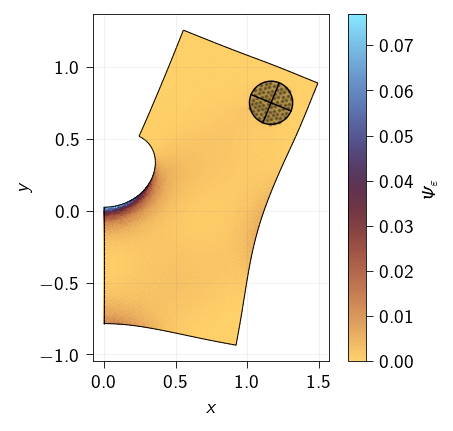

In [ ]:
# [Collapse: code] Visualization of the deformed configuration and strain energy density.

from matplotlib.tri import Triangulation
from matplotlib.collections import LineCollection

_u = jnp.zeros(n_dofs + 3).at[free_dofs].set(u_sol)
_u = apply_rigid_body_bc(_u)
u_solid = _u.at[:-3].get()
u_disk = _u.at[-3:].get()

u = u_solid.reshape(-1, n_dofs_per_node)

fig, ax = plt.subplots(figsize=(3.4, 3))
x_final = mesh.coords + u
tri = Triangulation(x_final[:, 0], x_final[:, 1], mesh.elements)

e_sig = strain_energy_mpc(op.grad(u), mat.mu, mat.lmbda).squeeze()
cb = ax.tripcolor(tri, e_sig, alpha=0.95, cmap="managua")
ax.set_aspect("equal")
plt.colorbar(cb, ax=ax, label=r"$\Psi_{\varepsilon}$")

edge_elems = jnp.concatenate(
    (
        pg["hole_boundary"],
        pg["left_edge"],
        pg["right_edge"],
        pg["bottom_edge"],
        pg["top_edge"],
    )
)
segments = mesh.coords[edge_elems][:, :, :2]
coll_boundary = LineCollection(
    segments + u[edge_elems][:, :, :2], colors="k", linewidths=0.5
)
ax.add_collection(coll_boundary)
ax.scatter(
    (mesh.coords[disk_nodes] + u[disk_nodes])[:, 0],
    (mesh.coords[disk_nodes] + u[disk_nodes])[:, 1],
    color="k",
    s=1,
    alpha=0.3,
)

rigid_circle = plt.Circle(
    disk_center + u_disk[:2],
    radius,
    color="k",
    fc="#0000003f",
    linewidth=0.7,
)
udx, udy, theta_d = u_disk
rigid_cross = plt.Line2D(
    [
        disk_center[0] + udx - np.cos(theta_d) * radius,
        disk_center[0] + udx + np.cos(theta_d) * radius,
    ],
    [
        disk_center[1] + udy - np.sin(theta_d) * radius,
        disk_center[1] + udy + np.sin(theta_d) * radius,
    ],
    color="k",
    linewidth=0.7,
)
rigid_cross_vertical = plt.Line2D(
    [
        disk_center[0] + udx - np.sin(theta_d) * radius,
        disk_center[0] + udx + np.sin(theta_d) * radius,
    ],
    [
        disk_center[1] + udy + np.cos(theta_d) * radius,
        disk_center[1] + udy - np.cos(theta_d) * radius,
    ],
    color="k",
    linewidth=0.7,
)
ax.add_line(rigid_cross)
ax.add_line(rigid_cross_vertical)
ax.add_artist(rigid_circle)

ax.grid()
ax.set(
    xlabel="$x$",
    ylabel="$y$",
)
plt.show()
#u_disk